# RNN from scatch
基于循环神经网络实现字符级语言模型

数据集：《The time machine》

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
batch_size,num_steps = 32,35
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)

## [独热编码]
将词元根据索引映射成不同的单位向量，向量的第 $index$ 处为 $1$ ，其余位置为 $0$ ，向量长度等于词表中的单词总数

In [3]:
F.one_hot(torch.tensor([0,2]),len(vocab))


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

每次采样的小批量数据形状是二维张量 `(batch_size,num_steps)` 

`one_hot` 函数将小批量数据转化为三维张量 `(num_steps,batch_size,len(vocab))` ，这样能更方便地通过最外层的维度，一步步地更新小批量数据的隐状态

In [4]:
X = torch.arange(10).reshape(2,5)
F.one_hot(X.T,28).shape

torch.Size([5, 2, 28])

# 初始化模型参数
隐藏单元数 `num_hiddens` 是一个可调参数

输入输出来自同一词表，维度相同，即词表大小（one_hot编码后）

In [46]:
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape,device=device) * 0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs,num_hiddens))
    W_hh = normal((num_hiddens,num_hiddens))
    b_h = torch.zeros(num_hiddens,device=device)
    # 输出层参数
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)
    # 附加梯度
    params = [W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad = True
    
    return params


# `RNN` 模型
首先需要一个在初始化时返回隐状态的函数，用于 *循环*

有的时候，隐状态会包含多个变量，用 *元组* 更便于处理

In [47]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

`rnn` 函数定义了在一个时间步内计算隐状态和输出，使用 `tanh` 作为激活函数，当元素在 $\mathbb{R}$ 满足均匀分布时，`tanh` 的均值为 $0$ 

In [48]:
def rnn(inputs,state,params):
    # inputs shape: (num_steps,batch_size,len(vocab))
    W_xh,W_hh,b_h,W_hq,b_q = params
    H, = state
    outputs = []
    # X shape: (batch_size,len(vocab))
    for X in inputs:
        H = torch.tanh(torch.matmul(X,W_xh) + torch.mm(H,W_hh) + b_h)
        Y = torch.mm(H,W_hq) + b_q
        outputs.append(Y)
    
    return torch.cat(outputs,dim=0),(H,)

定义类来封装函数，实现从零开始的循环神经网络 `RNN`

In [49]:
class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,get_params,init_state,forward_fn):
        self.vocab_size,self.num_hiddens = vocab_size,num_hiddens
        self.params = get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn = init_state,forward_fn
        
    def __call__(self,X,state):
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

检查输出是否具有正确形状，比如隐状态维度是否不变

In [50]:
num_hiddens = 512
net = RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),get_params,init_rnn_state,rnn)
state = net.begin_state(X.shape[0],d2l.try_gpu())
Y,new_state = net(X.to(d2l.try_gpu()),state)
Y.shape,len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

可以看到输出形状是 $(num\_steps\times batch\_size,\space len(vocab))$

隐状态保持不变，还是 $(batch\_size,\space num\_hiddens)$

# 预测
生成 `prefix` 之后的新字符。

预热期：循环遍历 `prefix` ，将隐状态传给下一时间步，但是不产生输出。模型会自我更新，但不会进行预测。预热期结束后，一般会比刚开始的初始值更适合预测

In [63]:
def predict_ch8(prefix,num_preds,net,vocab,device):
    '''在prefix后生成新字符'''
    state = net.begin_state(batch_size=1,device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda : torch.tensor(outputs[-1],device=device).reshape((1,1))
    for y in prefix[1:]: # 预热期
        _,state = net(get_input(),state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y,state = net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
        
    return ''.join([vocab.idx_to_token[i] for i in outputs])


In [64]:
predict_ch8("time traveller",10,net,vocab,d2l.try_gpu())

'time traveller the the t'

因为还没开始训练，所以结果很奇怪

## [梯度裁剪]
对长度为 $T$ 的序列，在反向传播计算 $T$ 个时间步上的梯度时，会产生 $\mathcal{O}(T)$ 的矩阵乘法链，当 $T$ 较大时，会导致数值不稳定，比如梯度消失或梯度爆炸。

使用 *梯度裁剪* 支持稳定训练

$g\leftarrow\min(1,\frac{\theta}{\|g\|})g$

- 当 $g$ 很大时，$\frac{\theta}{\|g\|}$ 很小，那么返回的是 $\frac{\theta}{\|g\|}g$ ，方向与原梯度一致，长度为给定半径 $\theta$ 的长度
- 当 $g$ 很小时，$\frac{\theta}{\|g\|}$ 很大，那么会返回 $1\cdot g=g$ ，此时不用担心梯度爆炸问题

In [53]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    
    norm = torch.sqrt(sum(torch.sum(p.grad ** 2) for p in params)) # 分母
    if norm > theta: # 大于1
        for param in params:
            param.grad[:] *= theta / norm

# 训练
首先定义一个函数在一个迭代周期内的训练模型：（1）不同采样方法，如随机采样和顺序分区会导致隐状态初始化的不同（2）更新参数前先进行梯度裁剪，防止梯度爆炸（3）使用困惑度评价模型
- 顺序分区：因为保留了拆分序列的顺序，因此上一个批次数据的最后一个样本的隐状态，可以用于初始化当前批次的第一个样本的隐状态，这能使存储在隐状态中的历史信息在一个迭代周期内流经所有批次，但也会带来梯度计算的复杂性，为了降低计算量，使隐状态的梯度计算限制在小批量数据的时间步内
- 随机采样：打乱了拆分序列的顺序，需要在每个迭代舟曲开始前重新初始化隐状态

In [57]:
def train_epoch(net,train_iter,loss,updater,device,use_random_iter):
    '''训练一个迭代周期'''
    state,timer = None,d2l.Timer()
    metric = d2l.Accumulator(2) # 训练损失之和 词元数量
    for X,Y in train_iter:
        if state is None or use_random_iter:
            '''第一个迭代周期or随机采样'''
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            if isinstance(net,nn.Module) and not isinstance(state,tuple):
                # state对于nn.GRU是一个张量
                state.detach_()
            else:
                # state对于LSTM或我们的模型是一个张量
                for s in state:
                    s.detach_()
        
        y = Y.T.reshape(-1)
        X,y = X.to(device),y.to(device)
        y_hat,state = net(X,state)
        l = loss(y_hat,y.long()).mean()
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)
        metric.add(1*y.numel(),y.numel())
    
    return math.exp(metric[0] / metric[1]),metric[1] / timer.stop()

In [74]:
def train(net,train_iter,vocab,lr,num_epochs,device,use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel="epoch",ylabel="perplexity",
                            legend=["train"],xlim=[10,num_epochs])
    # 初始化
    if isinstance(net,nn.Module):
        updater = torch.optim.SGD(net.parameters(),lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params,lr,batch_size)
    predict = lambda prefix: predict_ch8(prefix,50,net,vocab,device)
    
    # 训练和预测
    for epoch in range(num_epochs):
        ppl,speed = train_epoch(net,train_iter,loss,updater,device,use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict("time traveller"))
            animator.add(epoch + 1,[ppl])
            
    print(f"困惑度: {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}")
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度: 2.7, 32714.4 词元/秒 cpu
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


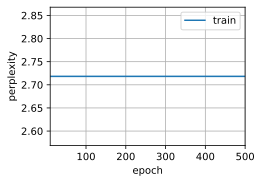

In [68]:
num_epochs,lr = 500,1
train(net,train_iter,vocab,lr,num_epochs,d2l.try_gpu())

尝试随机采样的方法

困惑度: 2.7, 31080.7 词元/秒 cpu
time travellerit s against reason said filbywas o li thon a mave
travellerit s against reason said filbywas o li thon a mave


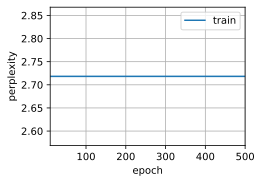

In [75]:
net = RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),get_params,init_rnn_state,rnn)
train(net,train_iter,vocab,lr,num_epochs,d2l.try_gpu(),use_random_iter=True)